In [1]:
import numpy as np
import os
import sys
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.datasets import make_swiss_roll
from sklearn.metrics import mean_squared_error

In [2]:
# Experiment parameters

k=3 # Number of principal components

## Dataset

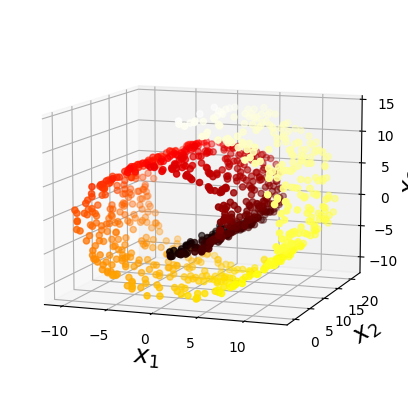

In [3]:
# Drawing on inspiration from https://docs.google.com/document/d/1lmaQowAhgf1OLbnSjl3X20j1idh-BdaQPZTrJslSJc0/edit "Kernel PCA" section

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

## Sparse PCA

<class 'numpy.ndarray'>
Z.shape: 1000 x 3
V.shape: 3 x 3
SPCA MSE reconstruction loss: 39.139838066560586


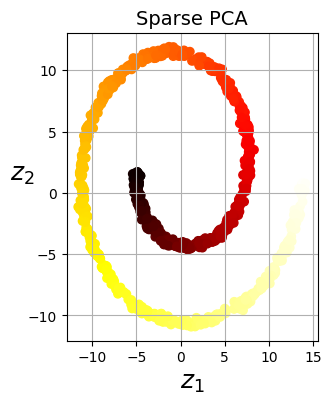

In [4]:
# TODO: hyperparameter search

#SparsePCA(n_components=k, alpha=1, ridge_alpha=0.01, max_iter=1000, tol=1e-08, method='lars', n_jobs=1, U_init=None, V_init=None, verbose=False, random_state=None)
spca = SparsePCA(n_components=k, ridge_alpha=0.0, alpha=10)
#spca = SparsePCA(n_components=k)

spca.fit(X)
print(type(spca.components_))
#V=np.tranpose(spca.components_) # Transpose to comply with SVD convention that V is features x components
V=spca.components_.transpose()
Z=spca.transform(X)
print("Z.shape:",Z.shape[0],"x",Z.shape[1])
print("V.shape:",V.shape[0],"x",V.shape[1])
X_preimage=Z @ V.transpose()
print("SPCA MSE reconstruction loss:",mean_squared_error(X, X_preimage))

#Drawing on inspiration from https://docs.google.com/document/d/1lmaQowAhgf1OLbnSjl3X20j1idh-BdaQPZTrJslSJc0/edit "Kernel PCA" section

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, spca, "Sparse PCA"),):
    X_reduced = pca.transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

## Kernel PCA

In [5]:
kpca_rbf = KernelPCA(n_components = k, kernel="rbf", gamma=0.04) #todo: choice of gamma? choice of kernel? Sweep?
kpca_rbf = kpca_rbf.fit_transform(X)

Kernel PCA ( Linear kernel ) MSE reconstruction loss: 51.58463490231284
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 32.78630879576611
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 42.472359340743786


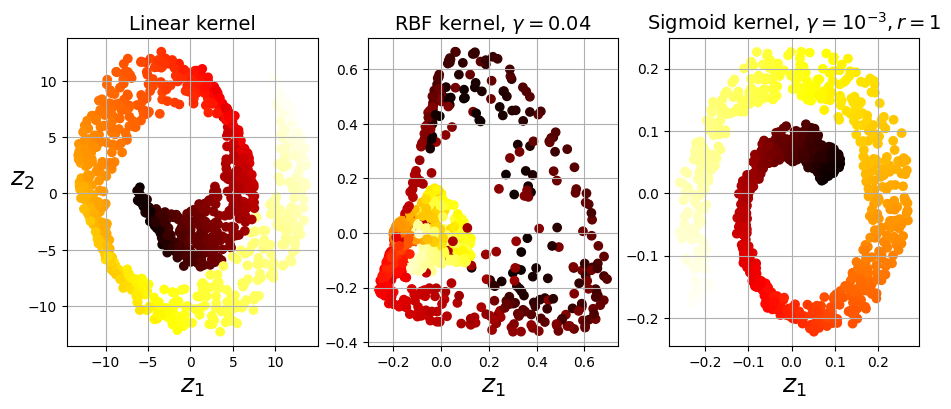

In [6]:
# Drawing on inspiration from https://docs.google.com/document/d/1lmaQowAhgf1OLbnSjl3X20j1idh-BdaQPZTrJslSJc0/edit "Kernel PCA" section
# TODO: hyperparameter sweep for kernel, gamma, coef0, other attributes

from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    X_preimage = pca.inverse_transform(X_reduced)
    print("Kernel PCA (",title,") MSE reconstruction loss:",mean_squared_error(X, X_preimage))
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [7]:
# Drawing on inspiration from https://docs.google.com/document/d/1lmaQowAhgf1OLbnSjl3X20j1idh-BdaQPZTrJslSJc0/edit "Kernel PCA" section
# TODO: hyperparameter sweep for kernel, gamma, coef0, other attributes

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

mean_squared_error(X, X_preimage)

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

In [31]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
rbf_pca = rbf_pca.fit(X)
X_reduced = rbf_pca.transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576611

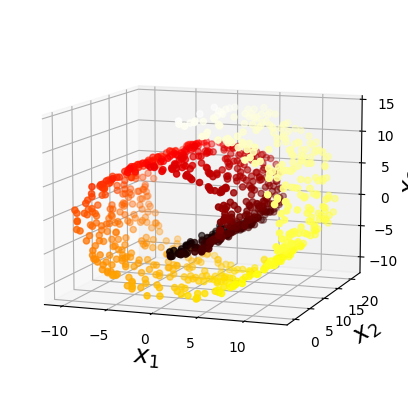

In [27]:
# Drawing on inspiration from https://docs.google.com/document/d/1lmaQowAhgf1OLbnSjl3X20j1idh-BdaQPZTrJslSJc0/edit "Kernel PCA" section

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

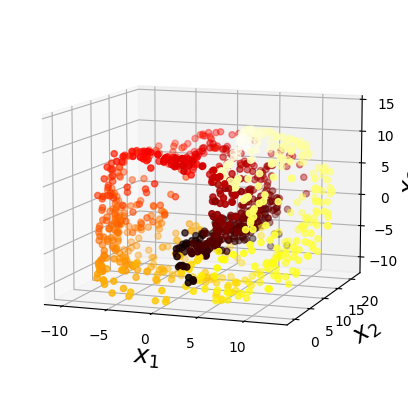

In [28]:
# Drawing on inspiration from https://docs.google.com/document/d/1lmaQowAhgf1OLbnSjl3X20j1idh-BdaQPZTrJslSJc0/edit "Kernel PCA" section

X=X_preimage

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()